In [21]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:

!pip install ultralytics pyyaml

In [23]:

import yaml
import os

yaml_path = '/content/drive/MyDrive/DIU_Class_Student-2/data.yaml'
dataset_base = '/content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset'

# Ensure paths
train_img_path = os.path.join(dataset_base, 'train', 'images')
val_img_path = os.path.join(dataset_base, 'val', 'images')

# Update YAML
data = {
    'path': dataset_base,
    'train': train_img_path,
    'val': val_img_path,
    'nc': 1,
    'names': ['student']
}

with open(yaml_path, 'w') as f:
    yaml.dump(data, f, indent=2)
print("✅ data.yaml updated.")

✅ data.yaml updated.


In [24]:
train_labels_path = os.path.join(dataset_base, 'train', 'labels')
val_labels_path = os.path.join(dataset_base, 'val', 'labels')
train_images_path = train_img_path
val_images_path = val_img_path


In [25]:
def get_empty_label_paths(label_dir, img_dir):
    empty_labels = []
    empty_images = []
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        if os.path.getsize(label_path) == 0:
            img_base = os.path.splitext(label_file)[0]
            img_found = False
            for ext in ['.jpg', '.jpeg', '.png']:
                img_path = os.path.join(img_dir, img_base + ext)
                if os.path.exists(img_path):
                    empty_labels.append(label_path)
                    empty_images.append(img_path)
                    img_found = True
                    break
            if not img_found:
                empty_labels.append(label_path)  # orphaned label
    return empty_labels, empty_images

print("🔍 Scanning for empty label files...")
empty_train_labels, empty_train_imgs = get_empty_label_paths(train_labels_path, train_images_path)
empty_val_labels, empty_val_imgs = get_empty_label_paths(val_labels_path, val_images_path)

print(f"   → Empty training labels: {len(empty_train_labels)}")
print(f"   → Empty validation labels: {len(empty_val_labels)}")

# Delete them
for p in empty_train_labels + empty_val_labels:
    os.remove(p)
for p in empty_train_imgs + empty_val_imgs:
    os.remove(p)
print("✅ Empty labels & images deleted.")

🔍 Scanning for empty label files...
   → Empty training labels: 0
   → Empty validation labels: 0
✅ Empty labels & images deleted.


In [26]:
def fix_class_ids(label_dir):
    fixed_count = 0
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
        new_lines = []
        modified = False
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                if parts[0] != '0':
                    parts[0] = '0'
                    modified = True
                new_lines.append(' '.join(parts) + '\n')
        if modified:
            with open(label_path, 'w') as f:
                f.writelines(new_lines)
            fixed_count += 1
    return fixed_count

train_fixed = fix_class_ids(train_labels_path)
val_fixed = fix_class_ids(val_labels_path)
print(f"✅ Class IDs fixed: {train_fixed} train, {val_fixed} val files updated.")


✅ Class IDs fixed: 0 train, 0 val files updated.


In [27]:
for cache in ['labels.cache', 'images.cache']:
    for root in [os.path.join(dataset_base, 'train'), os.path.join(dataset_base, 'val')]:
        cache_path = os.path.join(root, cache)
        if os.path.exists(cache_path):
            os.remove(cache_path)
print("✅ Cache cleared.")

✅ Cache cleared.


In [28]:

from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/DIU_Class_Student-2/yolov8n.pt')

print("🚀 Starting training (30 epochs, imgsz=416 for speed)...")
results = model.train(
    data=yaml_path,
    epochs=30,
    imgsz=416,
    batch=16,
    name='face_attendance_fast',
    augment=False,  # disable mosaic for speed
    cache=False
)


🚀 Starting training (30 epochs, imgsz=416 for speed)...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DIU_Class_Student-2/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/DIU_Class_Student-2/yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_attendance_fas

In [29]:

metrics = model.val()
print(f"\n📊 Results:")
print(f"   mAP50: {metrics.box.map50.item():.3f}")
print(f"   Precision: {metrics.box.p.item():.3f}")
print(f"   Recall: {metrics.box.r.item():.3f}")
# Calculate F1 score using the scalar items
precision_val = metrics.box.p.item()
recall_val = metrics.box.r.item()
if (precision_val + recall_val) > 0:
    f1_score = (2 * precision_val * recall_val) / (precision_val + recall_val)
else:
    f1_score = 0.0 # Handle case where precision and recall are both zero
print(f"   F1: {f1_score:.3f}")




Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 77.3±30.5 MB/s, size: 143.3 KB)
val: Scanning /content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/labels.cache... 98 images, 17 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 115/115 148.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.4it/s 3.4s
                   all        115        688      0.776       0.76      0.739      0.274
Speed: 2.9ms preprocess, 3.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/runs/detect/val6

📊 Results:
   mAP50: 0.739
   Precision: 0.776
   Recall: 0.760
   F1: 0.768



image 1/1 /content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/images/Scanned_20241113-1505-51.jpg: 416x416 23 students, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


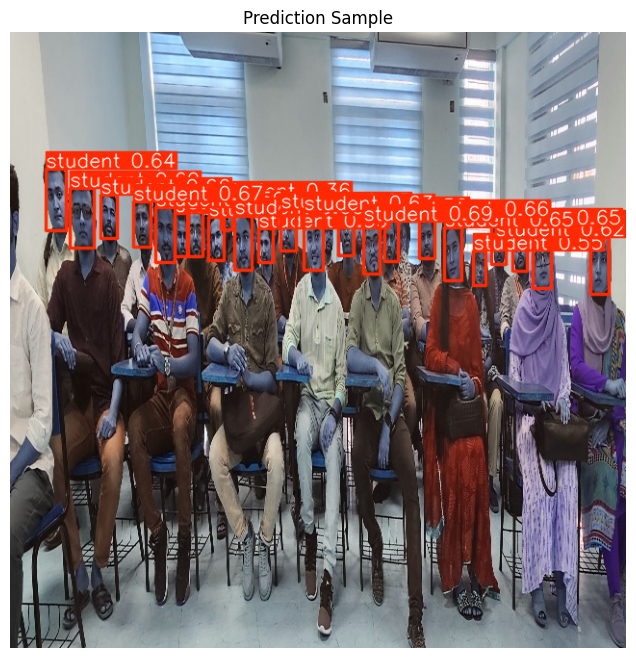

In [30]:

import matplotlib.pyplot as plt
from PIL import Image

# Pick a validation image
val_img_list = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.png'))]
if val_img_list:
    sample_img = os.path.join(val_images_path, val_img_list[0])
    result = model.predict(source=sample_img, conf=0.3, save=False)[0]

    plt.figure(figsize=(12, 8))
    plt.imshow(result.plot())
    plt.axis('off')
    plt.title("Prediction Sample")
    plt.show()
else:
    print("⚠️ No validation images found for preview.")


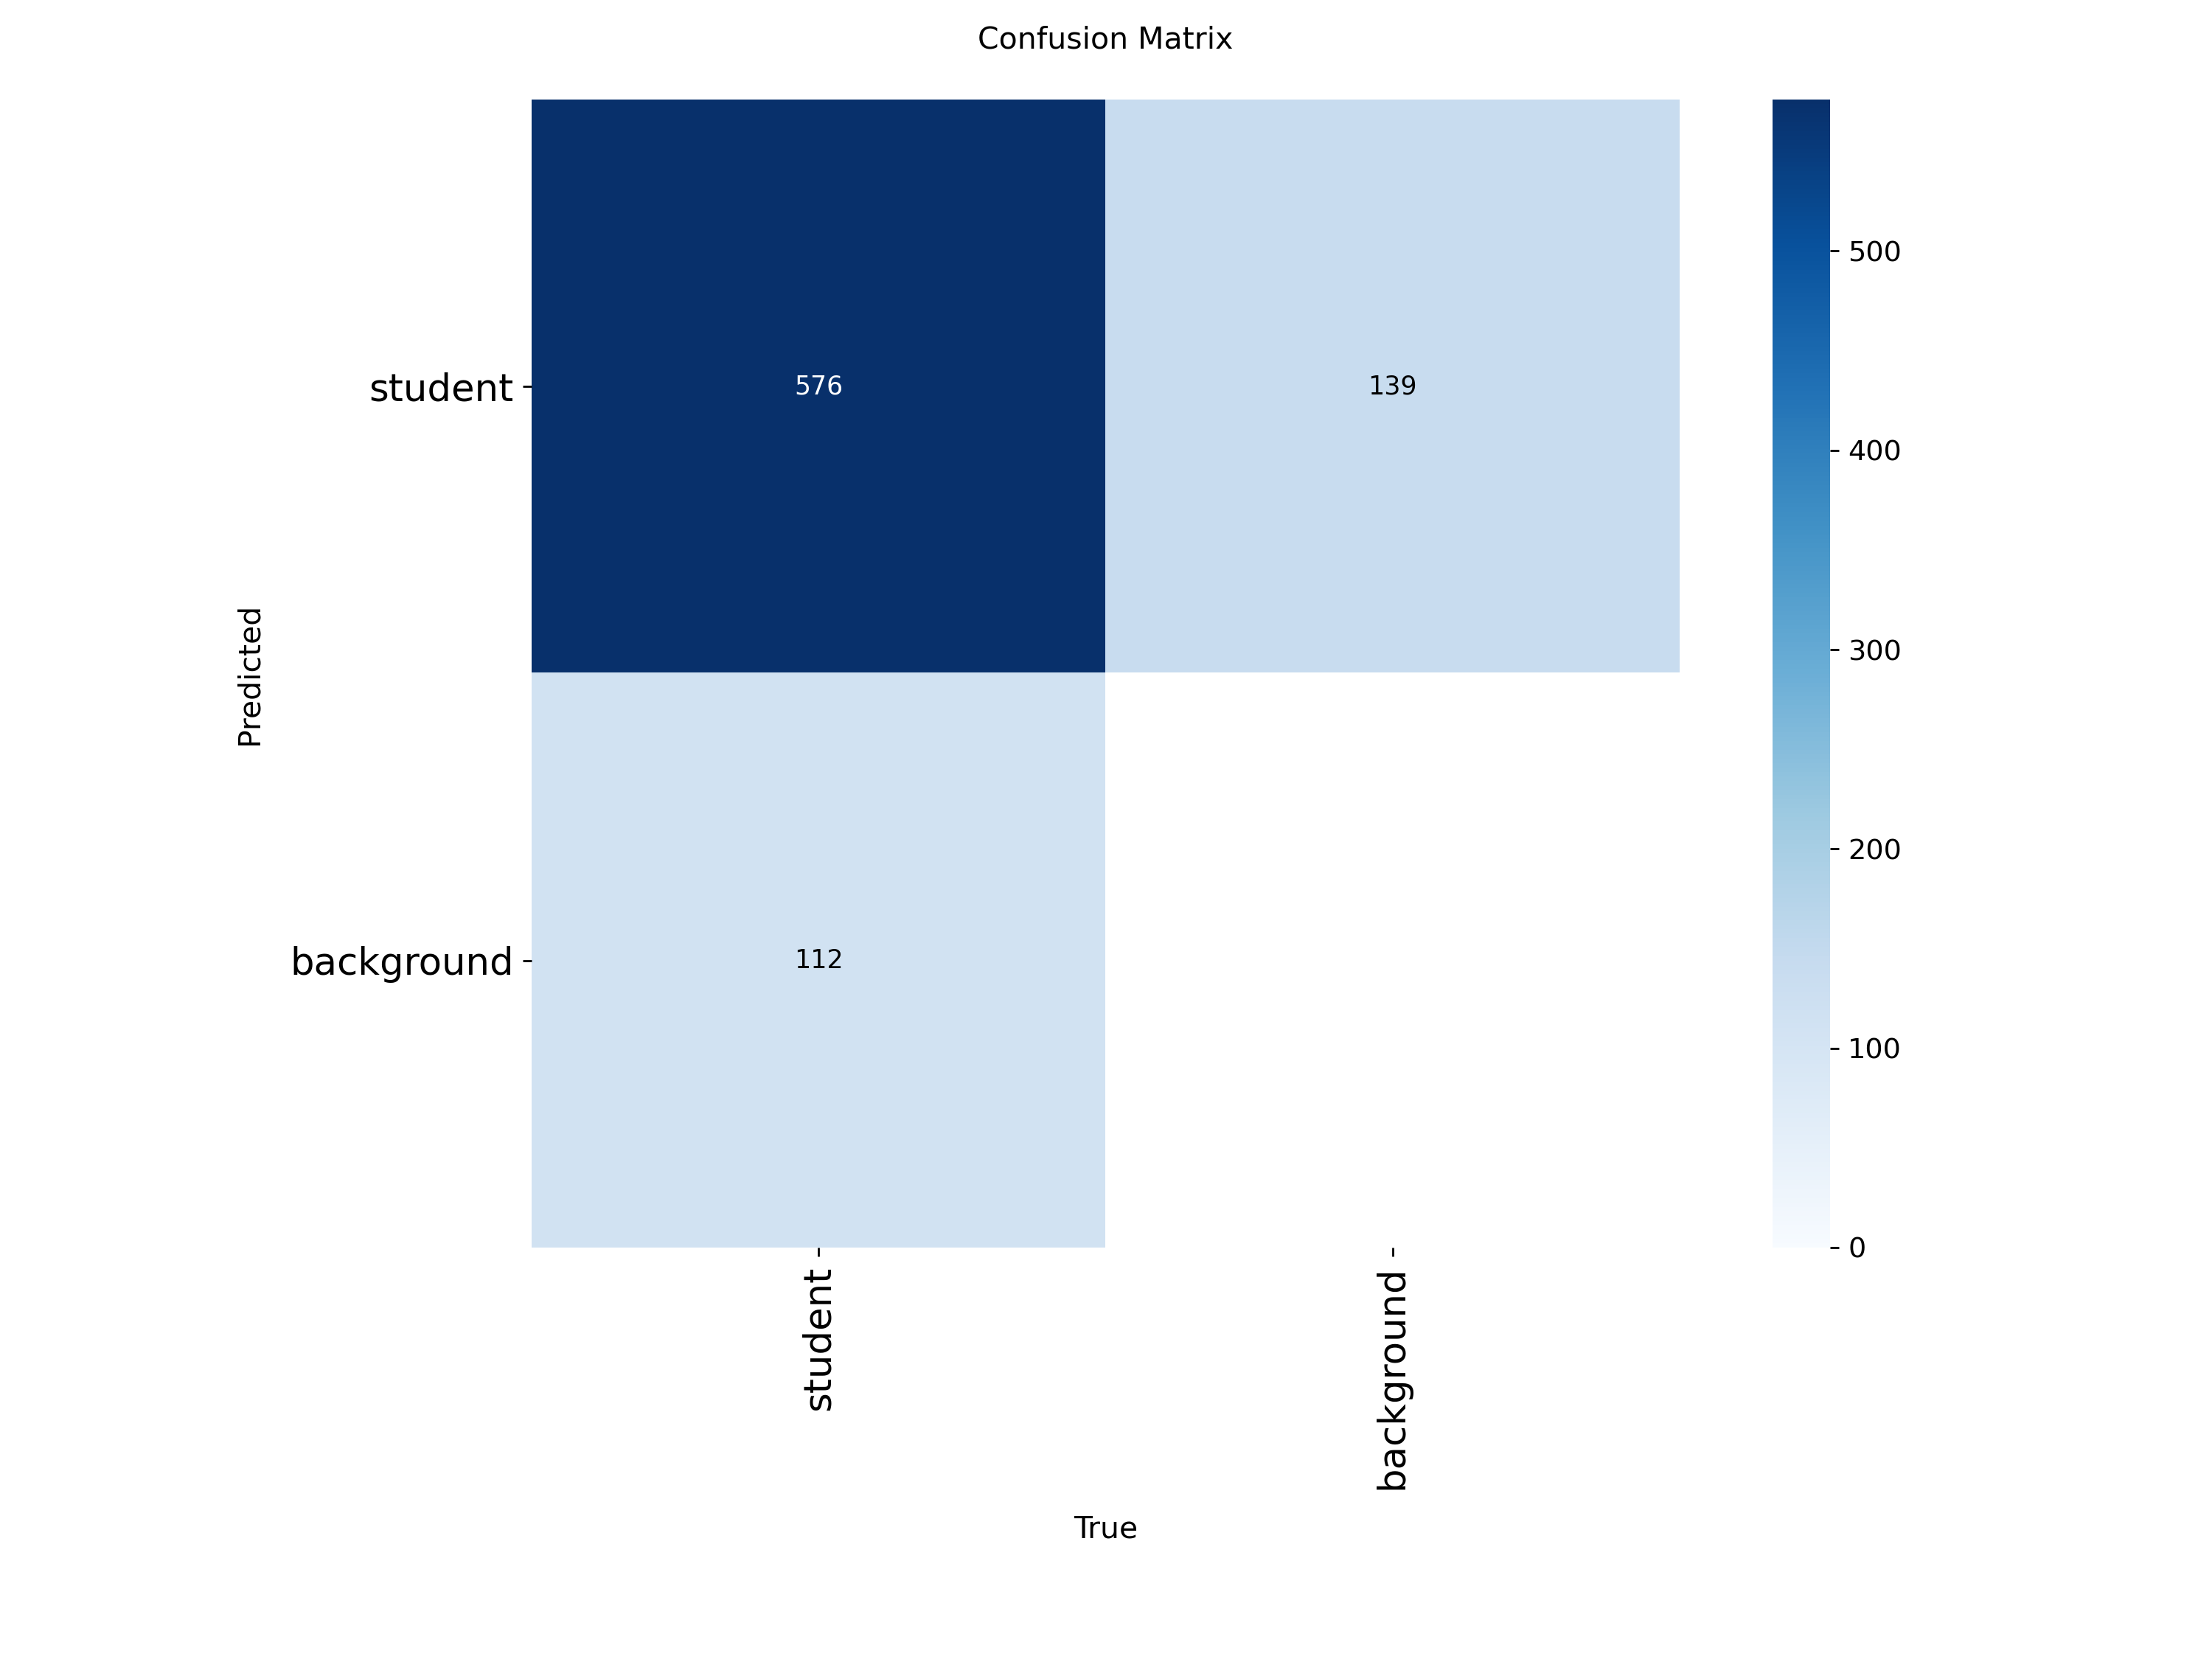

In [31]:
from IPython.display import Image as IPImage
import glob

cm_path = glob.glob('/content/runs/detect/*/confusion_matrix.png')
if cm_path:
    display(IPImage(filename=cm_path[0]))
else:
    print("⚠️ Confusion matrix not found. Check training output folder.")

In [32]:
# Validate the model
metrics = model.val()

# Run inference on a test image
# Replace '/content/drive/MyDrive/DIU_Class_Student-2/test_image.jpg' with a path to an actual image you want to test.
# For example, using one of the validation images:
results = model.predict(source='/content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/images/Scanned_20241113-1505-51.jpg', save=True, conf=0.5)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.5±0.3 ms, read: 63.2±20.0 MB/s, size: 165.1 KB)
val: Scanning /content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/labels.cache... 98 images, 17 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 115/115 165.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.9it/s 2.8s
                   all        115        688      0.776       0.76      0.739      0.274
Speed: 1.5ms preprocess, 3.6ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/runs/detect/val7

image 1/1 /content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/images/Scanned_20241113-1505-51.jpg: 416x416 19 students, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)
Results saved to /content/runs/detect/predict2


In [33]:
import os
import csv
from datetime import datetime
from ultralytics import YOLO
from pathlib import Path

# ----------------------------
# CONFIG
# ----------------------------
MODEL_PATH = '/content/runs/detect/face_attendance_fast2/weights/best.pt'  # Corrected path
TEST_IMAGES_DIR = '/content/drive/MyDrive/DIU_Class_Student-2/test_images'  # create this folder
CSV_LOG_PATH = '/content/drive/MyDrive/DIU_Class_Student-2/attendance_log.csv'

# Load model
model = YOLO(MODEL_PATH)

# Ensure test dir exists
os.makedirs(TEST_IMAGES_DIR, exist_ok=True)

# Get image paths
image_paths = [os.path.join(TEST_IMAGES_DIR, f)
               for f in os.listdir(TEST_IMAGES_DIR)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Initialize CSV
csv_exists = os.path.exists(CSV_LOG_PATH)
with open(CSV_LOG_PATH, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    if not csv_exists:
        writer.writerow(['Timestamp', 'Image_Name', 'Students_Detected'])

    # Process each image
    for img_path in image_paths:
        results = model(img_path, conf=0.3)
        num_students = len(results[0].boxes)  # number of detected faces

        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        img_name = os.path.basename(img_path)

        writer.writerow([timestamp, img_name, num_students])
        print(f"[{timestamp}] {img_name} → {num_students} student(s) detected")

print(f"\n✅ Attendance log saved to: {CSV_LOG_PATH}")


✅ Attendance log saved to: /content/drive/MyDrive/DIU_Class_Student-2/attendance_log.csv


In [34]:
from ultralytics import YOLO

# Load trained model
# Corrected path to the best.pt file from the last successful training run
model = YOLO('/content/runs/detect/face_attendance_fast2/weights/best.pt')

# Export to ONNX
onnx_model_path = model.export(
    format='onnx',
    imgsz=416,          # must match training size or be compatible
    dynamic=False,      # set True if you want dynamic input shapes
    simplify=True       # applies ONNX simplification (recommended)
)

print(f"✅ ONNX model exported to: {onnx_model_path}")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/face_attendance_fast2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (5.9 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.78...
ONNX: export success ✅ 1.3s, saved as '/content/runs/detect/face_attendance_fast2/weights/best.onnx' (11.6 MB)

Export complete (1.6s)
Results saved to /content/runs/detect/face_attendance_fast2/weights
Predict:         yolo predict task=detect model=/content/runs/detect/face_attendance_fast2/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=/content/runs/detect/face_attendance_fast2/weights/best.onnx imgsz=416 data=/content/drive/MyDrive/DIU_Class_Student-2/data.yaml  
Visualize:       https://netron.app
✅ ONNX model exported to: /content/runs/de

In [ ]:
from ultralytics import YOLO

# Assuming yaml_path is defined from previous cells (e.g., in cell qWEchkcLBzaY)
# It should be '/content/drive/MyDrive/DIU_Class_Student-2/data.yaml'
# If not, you might need to re-run the cell where yaml_path is defined.

# Load the pretrained YOLOv8n model from the correct path in Google Drive
model = YOLO('/content/drive/MyDrive/DIU_Class_Student-2/yolov8n.pt')

# Train the model, specifying the full path to data.yaml
model.train(data=yaml_path, epochs=30, imgsz=416, batch=16)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DIU_Class_Student-2/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/DIU_Class_Student-2/yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

In [ ]:
python scripts/log_attendance.py --image_dir test_images/ --model runs/detect/train/weights/best.pt

In [ ]:
from ultralytics import YOLO
model = YOLO('best.pt')
model.export(format='onnx', simplify=True)

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load your trained model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # or last.pt

# Pick 2–4 validation images
val_img_dir = '/content/drive/MyDrive/DIU_Class_Student-2/Class_student_dataset/val/images'
image_files = [f for f in os.listdir(val_img_dir) if f.lower().endswith(('.jpg', '.png'))][:4]

plt.figure(figsize=(16, 10))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(val_img_dir, img_file)
    result = model(img_path, conf=0.3)[0]

    plt.subplot(2, 2, i + 1)
    plt.imshow(result.plot())
    plt.axis('off')
    plt.title(f'Sample {i+1}')

plt.tight_layout()
plt.savefig('/content/docs/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Download manually or copy to Drive
!cp /content/docs/sample_predictions.png "/content/drive/MyDrive/DIU_Class_Student-2/"